In [1]:
import os
import errno

import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K

from deepcell.utils.data_utils import make_training_data
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D
from deepcell.training import train_model_conv
from deepcell.training import train_model_sample

Using TensorFlow backend.


## Load the Training Data

In [2]:
RESIZE = True
RESHAPE_SIZE = 512

# filepath constants 
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/ecoli/kc'
DATA_FILE = 'ecoli_kc'.format(K.image_data_format())

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 3

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    dimensionality=2,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, DATA_FILE),
    training_direcs=['set1', 'set2'],
    channel_names=['phase'],
    raw_image_direc='processed',
    annotation_direc='annotated',
    reshape_size=RESHAPE_SIZE if RESIZE else None)

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Reshaped feature data from (2, 1002, 1004, 1) to (8, 512, 512, 1)
Reshaped training data from (2, 1002, 1004, 1) to (8, 512, 512, 1)
Data Saved to /data/npz_data/cells/ecoli/kc/ecoli_kc.npz


## Fully Convolutional Training

In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])
    
# Set up other training parameters
n_epoch = 32
batch_size = 1
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (8, 512, 512, 1)
y.shape: (8, 512, 512, 1)


In [5]:
# Instantiate the model
conv_model = bn_feature_net_skip_2D(
    receptive_field=61,
    n_skips=2,
    n_features=3,  # (cell edge, cell interior, background)
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=input_shape,
    multires=False,
    last_only=False)

# Train the model
train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,
    expt='conv',
    transform='deepcell',
    dilation_radius=1,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    skip=2,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (7, 512, 512, 1)
y_train shape: (7, 512, 512, 1)
X_test shape: (1, 512, 512, 1)
y_test shape: (1, 512, 512, 1)
Output Shape: (None, 512, 512, 3)
Number of Classes: 3
(None, 512, 512, 3)
Epoch 1/32
6/7 [========================>.....] - ETA: 1s - loss: 2.9254 - model_1_loss: 0.9539 - model_2_loss: 0.9366 - model_3_loss: 1.0140 - model_1_acc: 0.2680 - model_2_acc: 0.3229 - model_3_acc: 0.3711
Epoch 00001: val_loss improved from inf to 4.32326, saving model to /data/models/cells/ecoli/kc/2018-08-31_ecoli_kc_conv.h5
7/7 [==============================] - 11s 2s/step - loss: 2.9448 - model_1_loss: 0.9632 - model_2_loss: 0.9504 - model_3_loss: 1.0103 - model_1_acc: 0.3017 - model_2_acc: 0.3509 - model_3_acc: 0.4028 - val_loss: 4.3233 - val_model_1_loss: 1.6683 - val_model_2_loss: 1.2154 - val_model_3_loss: 1.4186 - val_model_1_acc: 0.8071 - val_model_2_acc: 0.8052 - val_model_3_acc: 0.8084
Epoch 2/32
6/7 [========================>.....] - ETA: 0s - loss: 2.1441 - model_1_loss:

Epoch 13/32
6/7 [========================>.....] - ETA: 0s - loss: 1.1994 - model_1_loss: 0.3916 - model_2_loss: 0.3868 - model_3_loss: 0.4000 - model_1_acc: 0.7917 - model_2_acc: 0.8098 - model_3_acc: 0.8069
Epoch 00013: val_loss improved from 1.95076 to 1.82306, saving model to /data/models/cells/ecoli/kc/2018-08-31_ecoli_kc_conv.h5
7/7 [==============================] - 3s 479ms/step - loss: 1.1529 - model_1_loss: 0.3773 - model_2_loss: 0.3711 - model_3_loss: 0.3834 - model_1_acc: 0.7827 - model_2_acc: 0.8034 - model_3_acc: 0.7984 - val_loss: 1.8231 - val_model_1_loss: 0.5502 - val_model_2_loss: 0.6374 - val_model_3_loss: 0.6144 - val_model_1_acc: 0.8519 - val_model_2_acc: 0.7141 - val_model_3_acc: 0.8805
Epoch 14/32
6/7 [========================>.....] - ETA: 0s - loss: 1.0372 - model_1_loss: 0.3307 - model_2_loss: 0.3389 - model_3_loss: 0.3465 - model_1_acc: 0.8190 - model_2_acc: 0.8222 - model_3_acc: 0.8224
Epoch 00014: val_loss improved from 1.82306 to 1.63517, saving model to /

Epoch 25/32
6/7 [========================>.....] - ETA: 0s - loss: 0.8994 - model_1_loss: 0.2799 - model_2_loss: 0.2970 - model_3_loss: 0.3014 - model_1_acc: 0.8213 - model_2_acc: 0.8187 - model_3_acc: 0.8158
Epoch 00025: val_loss did not improve
7/7 [==============================] - 3s 442ms/step - loss: 0.8578 - model_1_loss: 0.2681 - model_2_loss: 0.2841 - model_3_loss: 0.2844 - model_1_acc: 0.8166 - model_2_acc: 0.8157 - model_3_acc: 0.8147 - val_loss: 1.1110 - val_model_1_loss: 0.3782 - val_model_2_loss: 0.3428 - val_model_3_loss: 0.3688 - val_model_1_acc: 0.9233 - val_model_2_acc: 0.9199 - val_model_3_acc: 0.9253
Epoch 26/32
6/7 [========================>.....] - ETA: 0s - loss: 0.7535 - model_1_loss: 0.2463 - model_2_loss: 0.2368 - model_3_loss: 0.2493 - model_1_acc: 0.8098 - model_2_acc: 0.8130 - model_3_acc: 0.8079
Epoch 00026: val_loss improved from 1.07209 to 1.04227, saving model to /data/models/cells/ecoli/kc/2018-08-31_ecoli_kc_conv.h5
7/7 [==============================

In [6]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')

train_dict, test_dict = get_data(training_data_file, mode='conv', seed=21)

X_test, y_test = test_dict['X'], test_dict['y']

test_images = conv_model.predict(X_test)[-1]

print('model output shape:', test_images.shape)

model output shape: (1, 512, 512, 3)


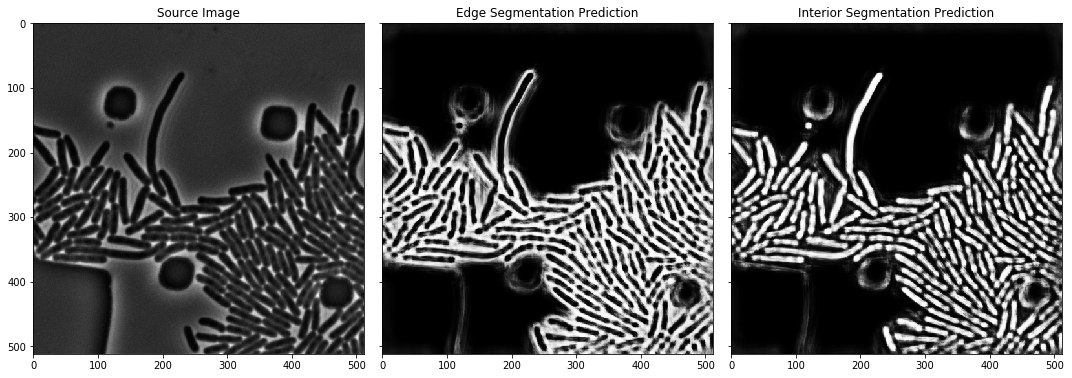

In [7]:
# Plot the results
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0], cmap='gray')
ax[0].set_title('Source Image')

ax[1].imshow(test_images[index, :, :, 0], cmap='gray')
ax[1].set_title('Edge Segmentation Prediction')

ax[2].imshow(test_images[index, :, :, 1], cmap='gray')
ax[2].set_title('Interior Segmentation Prediction')

fig.tight_layout()
plt.show()

## Sample Based Training

In [8]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Sample window dimensions
WIN_X = 30
WIN_Y = 30

# Set up training parameters
n_epoch = 3
batch_size = 64
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=.99)

X.shape: (8, 512, 512, 1)
y.shape: (8, 512, 512, 1)


In [9]:
# Instantiate the model
sample_model = bn_feature_net_2D(
    receptive_field=WIN_X + WIN_Y + 1,
    n_features=3,
    reg=1e-5,
    norm_method='median',
    n_channels=X.shape[CHANNEL_AXIS])

# Train the model
train_model_sample(
    model=sample_model,
    dataset=DATA_FILE,
    expt='sample',
    transform='deepcell',
    dilation_radius=1,
    optimizer=optimizer,
    batch_size=batch_size,
    window_size=(WIN_X, WIN_Y),
    balance_classes=True,
    max_class_samples=None,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (7, 512, 512, 1)
y_train shape: (7, 512, 512, 1)
X_test shape: (1, 512, 512, 1)
y_test shape: (1, 512, 512, 1)
Output Shape: (None, 3)
Number of Classes: 3
Epoch 1/3
4076/4078 [============================>.] - ETA: 0s - loss: 0.4283 - acc: 0.7966
Epoch 00001: val_loss improved from inf to 0.01263, saving model to /data/models/cells/ecoli/kc/2018-08-31_ecoli_kc_sample.h5
4078/4078 [==============================] - 144s 35ms/step - loss: 0.4283 - acc: 0.7966 - val_loss: 0.0126 - val_acc: 1.0000
Epoch 2/3
4077/4078 [============================>.] - ETA: 0s - loss: 0.4057 - acc: 0.8083
Epoch 00002: val_loss did not improve
4078/4078 [==============================] - 147s 36ms/step - loss: 0.4058 - acc: 0.8083 - val_loss: 0.0128 - val_acc: 1.0000
Epoch 3/3
4076/4078 [============================>.] - ETA: 0s - loss: 0.3938 - acc: 0.8167
Epoch 00003: val_loss did not improve
4078/4078 [==============================] - 149s 37ms/step - loss: 0.3938 - acc: 0.8167 - val_loss

In [11]:
# With the trained models, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')

train_dict, test_dict = get_data(training_data_file, mode='sample', seed=21)

X_test, y_test = test_dict['X'], test_dict['y']

# Re-initializing dilated models for sample-mode predictions
sample_weights_file = '2018-08-31_ecoli_kc_sample.h5'
sample_weights_file = os.path.join(MODEL_DIR, PREFIX, sample_weights_file)

run_sample_model = bn_feature_net_2D(
    receptive_field=WIN_X + WIN_Y + 1,
    n_features=3,
    norm_method='median',
    dilated=True,
    input_shape=X_test.shape[1:])
run_sample_model.load_weights(sample_weights_file)

test_images = run_sample_model.predict(X_test)

print('model output shape:', test_images.shape)

model output shape: (1, 512, 512, 3)


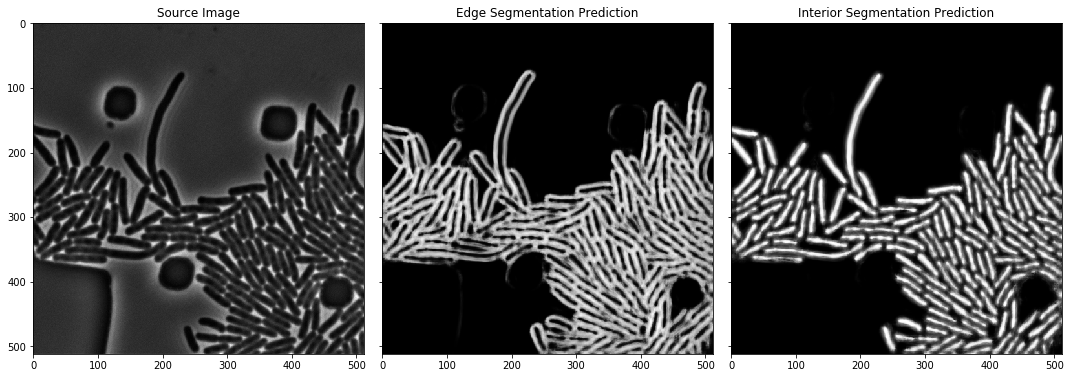

In [12]:
# Plot the results
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0], cmap='gray')
ax[0].set_title('Source Image')

ax[1].imshow(test_images[index, :, :, 0], cmap='gray')
ax[1].set_title('Edge Segmentation Prediction')

ax[2].imshow(test_images[index, :, :, 1], cmap='gray')
ax[2].set_title('Interior Segmentation Prediction')

fig.tight_layout()
plt.show()